In [4]:
import numpy as np
import camb
import matplotlib.pyplot as plt

In [2]:
class EisensteinHu:
    def __init__(self, ombh2=0.022, omch2=0.122,h=0.675, mnu=0.06, ns=0.965, As=2e-9, tau=0.06, TCMB=2.728):
        self.name = "Eisenstein-Hu"
        self.params = {
            'ombh2': ombh2,
            'omch2': omch2,
            'h': h,
            'mnu': mnu,
            'ns': ns,
            'As': As,
            'tau': tau,
            'TCMB': TCMB
        }
        self.h = self.params['h']
        self.ombh2 = self.params['ombh2']
        self.omch2 = self.params['omch2']
        self.om0h2 = ombh2 + omch2
        self.f_baryon = ombh2/self.om0h2
        self.theta = TCMB/2.7
        self.zeq = 2.5*1e4 * self.om0h2 * (self.theta)**-4
        self.keq = 7.46*1e-2 * self.om0h2*(self.theta)**-2 # in Mpc^-1

        # k_silk calculation
        self.ksilk = 1.6 * self.ombh2**0.52 * self.om0h2**0.73 * ( 1+ (10.4*self.om0h2) ** -0.95 ) # in Mpc^-1

    # calculate zdrag [4]

        self.z_drag_b1 = 0.313 * self.om0h2 ** -0.419 * (1 + 0.607 * self.om0h2 ** 0.674)
        self.z_drag_b2 = 0.238 * self.om0h2 ** 0.223
        self.ombh2 = self.params['ombh2']
        self.zdrag    = 1291 * self.om0h2 ** 0.251 / (1. + 0.659 * self.om0h2 ** 0.828) * \
                           (1. + self.z_drag_b1 * self.ombh2 ** self.z_drag_b2) # [4]

    # calculate s (sound horizon)    [6]
        self.Req = 31.5*self.ombh2*(self.theta)**-4 * (1e3/self.zeq)
        self.Rdrag = 31.5*self.ombh2*(self.theta)**-4 * (1e3/self.zdrag)
        self.s = 2. / (3.*self.keq) * np.sqrt(6. / self.Req) * \
                    np.log((np.sqrt(1 + self.Rdrag) + np.sqrt(self.Rdrag + self.Req)) / (1 + np.sqrt(self.Req)) )
    # Calculate alpha_c, beta_c [11],[12]
        a1 = (46.9*self.om0h2)**0.670*(1+(32.1*self.om0h2)**-0.532)
        a2 = (12.0*self.om0h2)**0.424*(1+(45.0*self.om0h2)**-0.582)
        self.alpha_c = a1**(-self.f_baryon)*a2**(-self.f_baryon**3) # [11]
        
        b1 = 0.944 / (1 + (458*self.om0h2) ** -0.708)
        b2 =  0.395 * self.om0h2 ** -0.0266
        self.beta_c = 1. / ( 1 + b1 * ((1-self.f_baryon) ** b2 - 1) ) # [12]

    # Calculate alpha_b [14]
        def G(y): # [15]
                return y * ( (-6. * np.sqrt(1 + y)) + ( (2 + 3 * y) * np.log( (np.sqrt(1+y) + 1) / (np.sqrt(1+y)-1) ) ) )
        self.alpha_b = 2.07*self.keq*self.s*(1+self.Rdrag)**-(3/4)*G((1+self.zeq)/(1+self.zdrag)) # [14]    
        self.beta_node = 8.41*self.om0h2**0.435 # [23]
        self.beta_b = 0.5 + self.f_baryon + ( 3 - 2*self.f_baryon )*np.sqrt( (17.2*self.om0h2)**2 + 1) # [24]
    def Transfer_function_eff(self,k):
        q = k/(13.41*self.keq) # [10]
        ks = k*self.s
        T_c = self.alpha_c * np.log(18*self.beta_c*q) / (14.2*q**2) # [9]
        T_b = self.alpha_b * np.sin(ks)/ks
        return (1-self.f_baryon)*T_c + self.f_baryon*T_b

    def Transfer_function(self, k):
        # Calculate T_c
        q = k/(13.41*self.keq) # [10]
        ks = k*self.s
        def C(alpha_c, q):  # [20]
            return 14.2/alpha_c + 386./(1+69.9*q**1.08)
        def Tilde0(q, alpha_c, beta_c): #  [19]
            return np.log(np.e+1.8*beta_c*q)/(np.log(np.e+1.8*beta_c*q)+C(alpha_c, q)*q**2)

        f = 1/(1+(ks/5.4)**4) # [18]
        T_c = f*Tilde0(q, 1, self.beta_c) + (1-f)*Tilde0(q, self.alpha_c, self.beta_c) # [17]

        # Calculate T_b
        self.stildek = self.s/((1+ (self.beta_node/ks)**3 )**(1/3)) # [22]
        def j0(x):
            return np.sin(x)/x
        T_b = ( Tilde0(q,1,1)/(1+(ks/5.2)**2) + self.alpha_b/(1+(self.beta_b/ks)**3) * np.exp(-(k/self.ksilk)**1.4) )  * j0(k*self.stildek) # [19]
        # Total Transfer function
        T_k = self.f_baryon*T_b + (1-self.f_baryon)*T_c # [16]
        return T_k
    def oscillation(self):
        s = 44.5 * np.log(9.83 / self.om0h2) / np.sqrt(1 + 10 * self.ombh2**3/4) # in Mpc [26]
        k_peak = 5* np.pi / (2*s) * (1 + 0.217 * self.om0h2) # in Mpc^-1 [25]
        return k_peak
    def Transfer_function_eff(self, k):
        self.gamma = self.om0h2/self.h
        q = k * self.theta**2
        def L0(q): # [29]
            return np.log(2*np.e + 1.8*q)
        def C0(q): # [30]
            return 14.2 + 731./(1+62.5*q)
        T0 = L0(q)/ (L0(q) + C0(q)*q**2) # [28]
        return T0
    
    

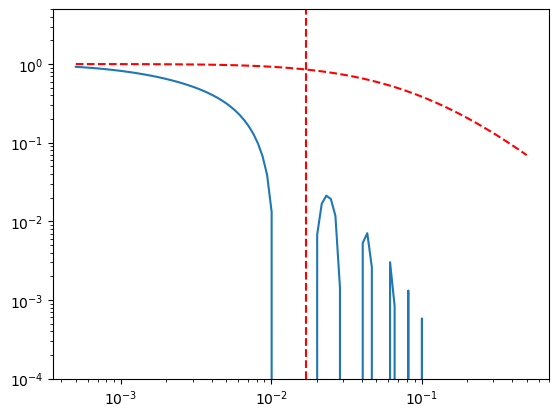

In [ ]:
om0h2 = 0.2*0.5**2
ombh2 = om0h2*1
pars = EisensteinHu(ombh2=ombh2, omch2=om0h2-ombh2, h=0.5)
karr = np.logspace(-3,0,50)
p= pars.Transfer_function(karr)
loc = pars.oscillation()
q = pars.Transfer_function_eff(karr)
plt.plot(karr*0.5, p)
plt.plot(karr*0.5, q, linestyle='--', color='red')
plt.axvline(loc*0.5, color='r', linestyle='--', label=f'First Peak at k={loc:.3f} Mpc$^{{-1}}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,5)
plt.show()


1020.3206045824348


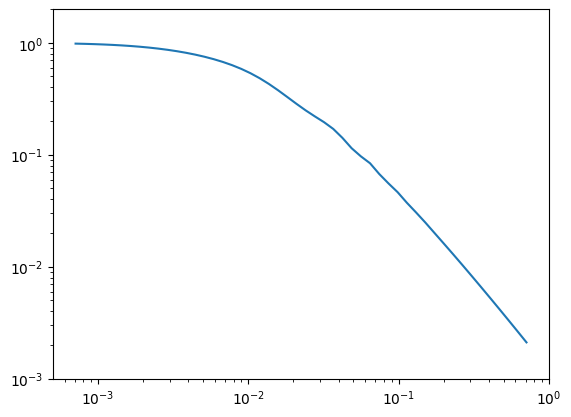

In [18]:
om0h2 = 0.13348568
ombh2 = 0.02258368
omch2 = om0h2 - ombh2

pars2 =  EisensteinHu(ombh2=ombh2, omch2=omch2, h=0.71, TCMB=2.725)
print(pars2.zdrag)
karr = np.logspace(-3,0,50)
p= pars2.Transfer_function(karr)
loc = pars2.oscillation()
q = pars2.Transfer_function_eff(karr)
plt.plot(karr*pars2.h, p)
#plt.plot(karr*pars2.h, q, linestyle='--', color='red')
#plt.axvline(loc*pars2.h, color='r', linestyle='--', label=f'First Peak at k={loc:.3f} Mpc$^{{-1}}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3,2)
plt.show()

In [54]:
print(pars.alpha_c*(om0h2-ombh2)/om0h2)
print(pars.alpha_b*ombh2/om0h2)
print(om0h2, pars.f_baryon)

0.5536167979002934
0.09441023832083474
0.2 0.20000000000000004


In [7]:
from numcosmo_py import Nc, Ncm

# Initialize the library
Ncm.cfg_init()
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo["Omegak"] = 0.0
cosmo["w"] = -1.0
cosmo["Omegab"] = ombh2/0.5**2
cosmo["Omegac"] = (om0h2 - ombh2)/0.5**2
cosmo["H0"] = 50.0

In [3]:
tf_eh = Nc.TransferFuncEH.new()

In [21]:
T_k_nc = tf_eh(cosmo, karr)

# 3. 결과 플롯
plt.figure(figsize=(8, 6))
plt.plot(karr, T_k_nc, label='NumCosmo (Eisenstein & Hu)')

# 이전에 직접 구현한 결과와 비교 (단위 변환 필요: k_Mpc = k_hMpc * h)
h = cosmo.get_h()
plt.plot(karr / h, p, linestyle='--', label='Custom Implementation')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel('T(k)')
plt.title('Eisenstein & Hu Transfer Function')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

TypeError: 'TransferFuncEH' object is not callable